<a href="https://colab.research.google.com/github/yokayoka/noto-landslide-opencv/blob/main/template_03c3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

template matching 第3弾
rasterio により任意の範囲でラスターデータのclippingと書き出しを行って解析できる

[Intro to Python GIS](https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html) を参照

各ライブラリの解説についてはGIS奮戦記が詳しいので参照するとよい
[fiona](https://www.gis-py.com/entry/fiona)
[shapely](https://www.gis-py.com/entry/shapely)



In [1]:
# Colab にはrasterioが入っていないのでインストールする
!pip install rasterio
# fionaもインストール
!pip install fiona
# pycrsもインストール
!pip install pycrs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 88.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=0fa31d11ee09a3f0f84aa2346c7bb7565c03618a5a599a71091ddfdf11252e32
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built pycrs


In [2]:
# ライブラリのインポート
import cv2
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import folium
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
%matplotlib inline

https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


広域の陰影図とDEMの指定
下記のうち解析したいエリアのいずれか一つのセルを実行する。地震前のデータと地震後のデータは必ずフォルダーを別にする。

In [ ]:
# 陰影図とdemのpathを指定する
# ここは各自の環境に合わせて変更してください

fp_afs = "/content/drive/MyDrive/template_matching/makino/af_shade/af_shade_ED673_881.tif"
fp_bfs = "/content/drive/MyDrive/template_matching/makino/bf_shade/bf_shade_ED673_881.tif"

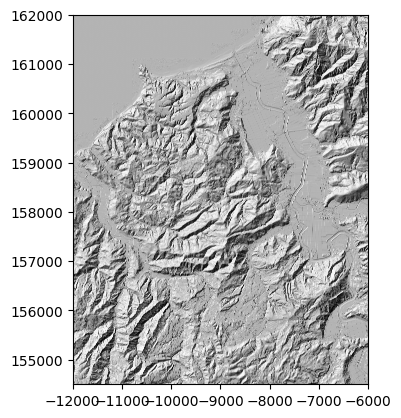

<Axes: >

In [35]:
# 地震後の陰影図全体をrasterioで読み込む
af_data = rasterio.open(fp_afs)
# rasterio.plot.show でデータを表示
show((af_data, 1), cmap='gray')

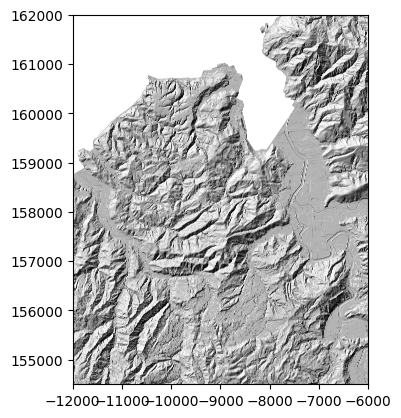

<Axes: >

In [36]:
# 地震前の陰影図全体をrasterioで読み込む
bf_data = rasterio.open(fp_bfs)
# rasterio.plot.show でデータを表示
show((bf_data, 1), cmap='gray')

In [ ]:
# bounding box を設定する
# ここは各自の関心エリアに合わせて変更してください
area_size = 1000

minx, miny = -10600, 157800
maxx, maxy = minx + area_size, miny + area_size
bbox = box(minx, miny, maxx, maxy)

In [38]:
# 平面直角7系のEPSGコードを設定しておく
epsg_code = 6675

In [39]:
# geodataframe の座標を表示する関数を定義
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [40]:
# ラスターを指定範囲でクリップしてそのパスを返す関数
def clip_raster(fp, x1: int, y1: int, x2: int, y2:int, epsg_code):
  data = rasterio.open(fp)
  # geopandas でbboxのgeodataframeを作成する
  geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(6675))
  # getFeature 関数を使ってbboxの座標をcorrdsとして取得
  coords = getFeatures(geo)
  # data からcoordの示す範囲内のデータを切り出す
  out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
  # 元のメタファイルを出力用のout_metaにコピーしておく
  out_meta = data.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": epsg_code})
  # geotiffを出力するpathの設定
  # ファイル名の設定 x座標については- (マイナス)をファイル名に使いたくないのでwに置換する
  fl = str(x1).replace('-', 'w') + "_" + str(y1) + "_" + str(x2).replace('-', 'w') + "_" + str(y2) + ".tif"
  # 出力先フォルダーの設定（元ファイルと同じ）
  #dr = fp[0:(-1*len(fp_afs.split("/")[-1]))]
  dr = os.path.dirname(fp)
  # out_tif = dr + "/" + fl
  out_tif = os.path.join(dr, fl)
  #print(out_tif)
  # 出力先にファイルを出力
  # Create the necessary directories if they don't exist
  os.makedirs(dr, exist_ok=True)
  with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
  # 出力ファイルのpathを戻り値として返す
  return out_tif
  # out_tif = dr + "/" + fl
  out_tif = os.path.join(dr, fl)
  #print(out_tif)
  # 出力先にファイルを出力
  with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
  # 出力ファイルのpathを戻り値として返す
  return out_tif

In [54]:
# 広域ラスター (shade) から指定領域をクリップする
bfs_clipped = clip_raster (fp_bfs, minx, miny, maxx, maxy, epsg_code)
afs_clipped = clip_raster (fp_afs, minx, miny, maxx, maxy, epsg_code)

print(afs_clipped)

<ipython-input-54-ab6183d10c3e>:2: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  bfs_clipped = clip_raster (fp_bfs, minx, miny, maxx, maxy, epsg_code)
<ipython-input-54-ab6183d10c3e>:3: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  afs_clipped = clip_raster (fp_afs, minx, miny, maxx, maxy, epsg_code)


/content/drive/MyDrive/template_matching/makino/af_shade/w10600_157800_w9600_158800.tif


In [55]:
# グレースケールで地震前後の画像を読み込む
af_image = cv2.imread(afs_clipped, cv2.IMREAD_GRAYSCALE)
bf_image = cv2.imread(bfs_clipped, cv2.IMREAD_GRAYSCALE)

# データが存在しない場合は警告する
if af_image is None:
    raise ValueError(f"Could not load image from path: {afs_clipped}")
if bf_image is None:
    raise ValueError(f"Could not load image from path: {bfs_clipped}")

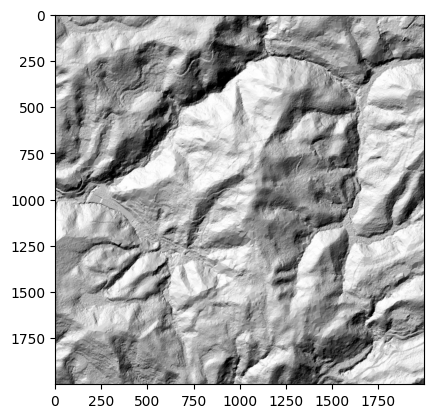

In [56]:
#　地震前の陰影図を表示
plt.imshow(bf_image, cmap='gray')

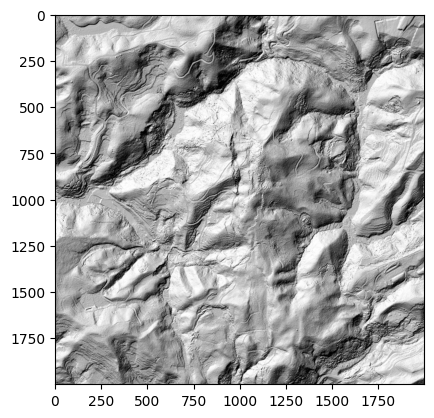

In [57]:
#　地震後の陰影図を表示
plt.imshow(af_image, cmap='gray')

In [58]:
# GDALで地図データの情報を取得
# https://gis4programmers.wordpress.com/2017/01/06/using-gdal-to-get-raster-extent/
# upy は画像南西のy座標らしい、平面直角なのでskewは0となる
bf_Src = gdal.Open(bfs_clipped)
upx, xres, xskew, upy, yskew, yres = bf_Src.GetGeoTransform()

In [59]:
bf_Src.GetGeoTransform()

(-10600.0, 0.5, 0.0, 158800.0, 0.0, -0.5)

In [60]:
# ピクセル座標を平面直角の地理座標（m）に変換する関数
def px2coords(px, py, upx, upy, xres, yres):
    x = upx + (px * xres)
    #y = upy - (py * yres)
    y = upy + (py * yres)
    return x, y

類似度: 0.8033591508865356
dx: -1.0m, dy: -0.5m


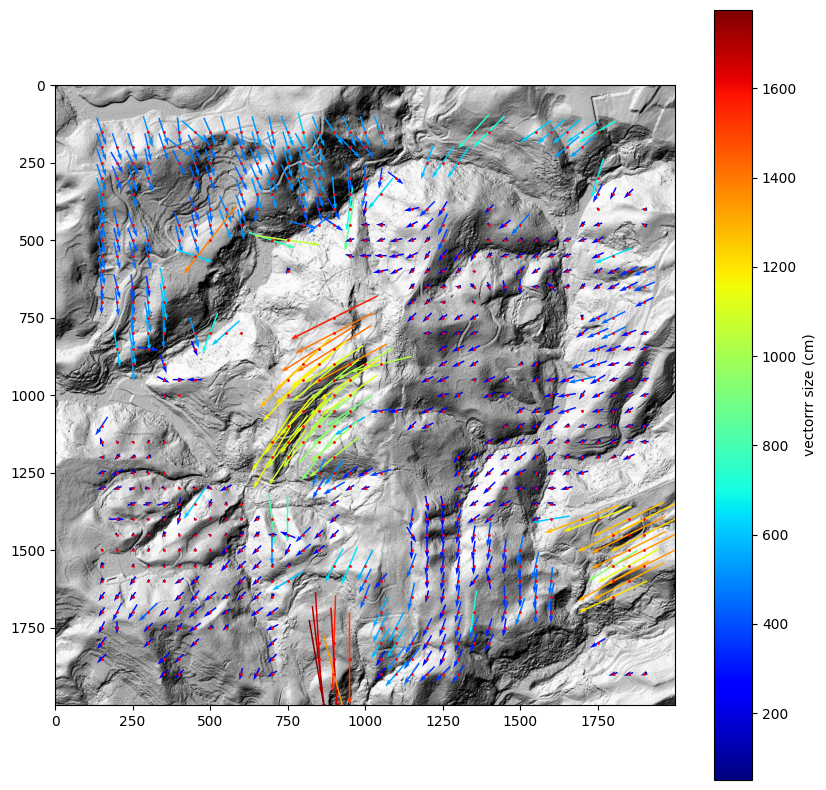

In [61]:
# Template matching の実行
# 画像のサイズ（pixel）を取得
x_size, y_size = bf_image.shape[0], bf_image.shape[1]
# テンプレート画像のサイズ（pixel単位）を設定する
win_size = 100

# データを格納するための空の配列を作成する
# 元画像のテンプレート取得元の北西端のピクセルx座標
l_nw_px =[]
# 元画像のテンプレート取得元の北西端のピクセルy座標
l_nw_py =[]

# 元画像のテンプレート取得元の南東端のピクセルx座標
l_se_px =[]
# 元画像のテンプレート取得元の南東端のピクセルy座標
l_se_py =[]

# 元画像のテンプレート取得元の中心ピクセル座標
l_center_px = []
l_center_py = []
# 平面直角座標
l_center_mx = []
l_center_my = []

# 照合先のピクセルx座標
l_target_px = []
# 照合先ピクセルy座標
l_target_py = []

# 照合先のメートルx座標（平面直角）
l_target_mx = []
# 照合先のメートルy座標（平面直角）
l_target_my = []

# 類似度
l_cr = []

# 変位量のx成分 pixel単位
l_dpx = []
# 変位量のy成分 pixel単位
l_dpy = []

# 変位量のx成分 m単位
l_dmx = []
# 変位量のy成分 m単位
l_dmy = []

# 変位量 m単位: dmx と dmy の平方和
l_dm =[]

# step はテンプレートのサイズの半分に設定する
step = int(win_size / 2)

# 開始点と終了点の設定
# 誤差を低減するために縁辺部は含まない
start = win_size
end_x = x_size - win_size
end_y = y_size - win_size

# 類似度の閾値を設定（類似度がこれ以上の場合にデータ出力）
threshold = 0.7
# 変位量の閾値を設定（変位量がこれ以下の場合にデータ出力、これ以上はエラーとみなす; m単位）
thres_dm =20

# yを北から南に移動
for y0 in range (start, end_y, step):
  # xを西から東に移動
  for x0 in range (start, end_x, step):
    # テンプレート画像の南東のピクセル座標を取得
    x1 = x0 + win_size
    y1 = y0 + win_size

    # テンプレート画像の取得
    # 地震前の画像（bf_image）の numpy array からテンプレート用の画像データを直接切り取っています。numpyの場合は、行 > 列の順でアドレスを指定するので
    # y->xの順になることに注意してください。
    template = bf_image[y0:y1, x0:x1]

    # テンプレートマッチングを実行
    result = cv2.matchTemplate(af_image, template, cv2.TM_CCOEFF_NORMED)
    # 最小値と最大値の位置を取得
    # 参考　https://www.codevace.com/py-opencv-min-max/
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # 類似度が最大になる場所のx, y のpixel座標を取得する
    target_px, target_py = max_loc[0], max_loc[1]

    # 類似度が最大になる場所のメートル（平面直角）
    target_mx = px2coords(target_px, target_py, upx, upy, xres, yres)[0]
    target_my = px2coords(target_px, target_py, upx, upy, xres, yres)[1]

    # 元画像のテンプレートの位置と類似度最大値の位置との差から変位量を取得
    # 北への移動と東への移動がそれぞれ正となる
    # pixelの差
    dpx = max_loc[0] - x0
    # m に換算
    dxm = dpx * xres

    # pixelの差
    dpy = max_loc[1] - y0
    # m に換算
    dym = dpy * yres

    # 変位量（dxmとdymの平方和）を算出
    dm = np.hypot(dxm, dym)

    # 類似度が閾値以上で変位量が閾値以下の場合に結果を出力する
    if max_val > threshold and dm < thres_dm:
      # テンプレートの北西端の座標データを追加
      l_nw_px.append(x0)
      l_nw_py.append(y0)

      # テンプレートの南東端の座標データを追加
      l_se_px.append(x1)
      l_se_py.append(y1)

      # テンプレートの中心点の座標データを追加
      center_px = int((x0 + x1)*0.5)
      center_py = int((y0 + y1)*0.5)
      l_center_px.append(center_px)
      l_center_py.append(center_py)
      center_mx = px2coords(center_px, center_py, upx, upy, xres, yres)[0]
      center_my = px2coords(center_px, center_py, upx, upy, xres, yres)[1]
      l_center_mx.append(center_mx)
      l_center_my.append(center_my)


      # 照合先ピクセルの位置をリストに追加
      l_target_px.append(target_px)
      l_target_py.append(target_py)

      # 照合先の位置のm座標をリストに追加
      l_target_mx.append(target_mx)
      l_target_my.append(target_my)
      # 類似度のリストへの追加
      l_cr.append(max_val)
      # 変位量データの追加（pixel）
      l_dpx.append(dpx)
      l_dpy.append(dpy)
      # 変位量データの追加（m）
      l_dmx.append(dxm)
      l_dmy.append(dym)
      # 変位量データの追加（m）の平方和
      l_dm.append(dm)
    else:
      continue

# 画面出力
#print(f'中心座標 pixel: {center_p}')
#print(f'座標 m: {center_xycord}')
print(f'類似度: {max_val}')
print(f'dx: {dxm}m, dy: {dym}m')

fln = bfs_clipped.split('/')[-1].split('.')[0] + "_w" + str(win_size) + ".png"
#out_fig_path = "/content/drive/MyDrive/IPU_Share/learning_opencv/template_matching/kamishoriki/fig"
out_fig_path = "/content/drive/MyDrive/template_matching/machino/fig"
out_path = os.path.join(out_fig_path, fln)

#　地震後の陰影図を表示してその上にベクトルを表示
# pivot = "mid" で線分の中央点に合わせる

# プロット用のarrayを作成。y方向は北が正になるのでyresをかけてピクセル差分の方向（南が正）から反転させる
plot_dpx = np.array(l_dpx) * xres
plot_dpy = np.array(l_dpy) * yres

# ベクトルの大きさを計算、値が小さいと色が表示されないので100をかけてcm単位とする
#mag = np.hypot(l_dpx, l_dpy) * 100 * xres
mag = np.hypot(plot_dpx, plot_dpy) * 100

fig, ax = plt.subplots(figsize = (10, 10))
ax.imshow(af_image, cmap='gray')
Q = ax.quiver(l_center_px, l_center_py, plot_dpx, plot_dpy, mag, pivot ="mid", cmap='jet', scale_units='xy', scale=0.05)
# Q = ax.quiver(l_center_px, l_center_py, plot_dpx, plot_dpy, mag, pivot ="mid", cmap='jet', scale_units='xy', scale=0.1)

fig.colorbar(Q, label='vectorrr size (cm)')
ax.scatter(l_center_px, l_center_py, color='red', s =1)

plt.savefig(out_path)


In [49]:
# 出力されたデータの長さを見てみる
len(l_dmx)

702

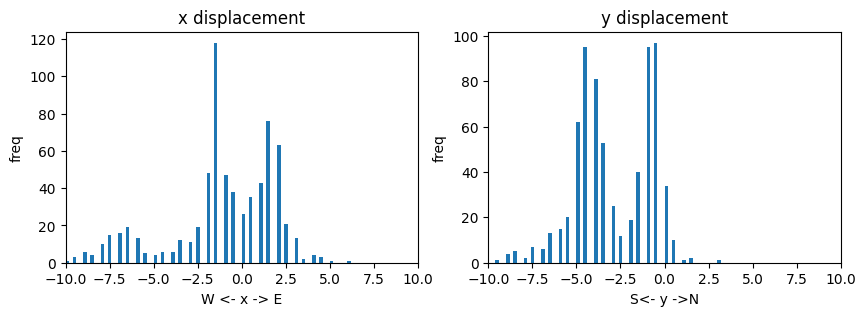

In [50]:
x_min = -10
x_max = 10

edges = np.arange(x_min, x_max, 0.2)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1,2,1)
ax.hist(l_dmx, bins=edges)
ax.set_title('x displacement')
ax.set_xlabel('W <- x -> E')
ax.set_ylabel('freq')
ax.set_xlim(x_min, x_max)

ax = fig.add_subplot(1,2,2)
ax.hist(l_dmy, bins=edges)
ax.set_title('y displacement')
ax.set_xlabel('S<- y ->N')
ax.set_ylabel('freq')
ax.set_xlim(x_min, x_max)

fig.show()

In [51]:
fln = bfs_clipped.split('/')[-1].split('.')[0] + "_w" + str(win_size) +".png"
out_fig_path = "/content/drive/MyDrive/shared_2025JPGU/data/fig"
out_path = os.path.join(out_fig_path, fln)


In [32]:
out_path

'/content/drive/MyDrive/shared_2025JPGU/data/fig/w5500_158500_w4500_159500_w100.png'